# admissionDrug

The following columns are available:

* admissiondrugid - primary key, has no meaning but identifies rows uniquely
* drugOffset - number of minutes from unit admit time that the admission drug was administered
* drugEnteredOffset - number of minutes from unit admit time that the admission drug was entered
* drugNoteType - unique note picklist types e.g.: Comprehensive Progress Admission Intubation
* specialtyType - physician specialty picklist types e.g.: anesthesiology gastroenterology oncology
* userType - who documented the drug from eCareManager user picklist types e.g.: eICU Physician, Nurse, Attending Physician
* rxincluded - Does the Note have associated Rx data: True or False
* writtenIneICU - Was the Note written in the eICU: True or False
* drugName - name of the selected admission drug e.g.: POTASSIUM CHLORIDE/D5NS METAXALONE PRAVACHOL
* drugDosage - dosage of the admission drug e.g.: 20.0000 400.000
* drugUnit - picklist units of the admission drug e.g.: mg mg/kg patch
* drugAdmitFrequency - picklist frequency with which the admission drug is administred e.g.: PRN twice a day at bedtime
* drughiclseqno - a code representing the drug (hierarchical ingredient code list, HICL)

We recommend configuring the `config.ini` file to allow for connection to the database without specifying your password each time.

In [17]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

In [18]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'mahdimoqri'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: mahdimoqri


In [19]:
conn_info

{'sqluser': 'mahdimoqri',
 'sqlpass': '',
 'sqlhost': 'localhost',
 'sqlport': 5432,
 'dbname': 'eicu',
 'schema_name': 'public,eicu_crd'}

## Examine a single patient

In [20]:
patientunitstayid = 2704494

In [21]:
query = query_schema + """
select *
from admissiondrug
where patientunitstayid = {}
order by drugoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,admissiondrugid,patientunitstayid,drugoffset,drugenteredoffset,drugnotetype,specialtytype,usertype,rxincluded,writtenineicu,drugname,drugdosage,drugunit,drugadmitfrequency,drughiclseqno
0,13383113,2704494,-87132,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,HYDRALAZINE HCL ...,0.0,,,89
1,13383111,2704494,-87132,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,COREG ...,0.0,,,13795
2,13383112,2704494,-87132,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,EXEMESTANE ...,0.0,,,20803
3,13383114,2704494,-87132,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,IMDUR ...,0.0,,,6341
4,13383116,2704494,-87132,2153,Comprehensive Progress,eCM Primary,THC Physician,True,False,PROTONIX ...,0.0,,,22008


In [22]:
# Look at a subset of columns
cols = ['admissiondrugid','patientunitstayid','drugoffset','drugenteredoffset','drugname','drughiclseqno']
df[cols].head()

,admissiondrugid,patientunitstayid,drugoffset,drugenteredoffset,drugname,drughiclseqno
0,13383113,2704494,-87132,2153,HYDRALAZINE HCL ...,89
1,13383111,2704494,-87132,2153,COREG ...,13795
2,13383112,2704494,-87132,2153,EXEMESTANE ...,20803
3,13383114,2704494,-87132,2153,IMDUR ...,6341
4,13383116,2704494,-87132,2153,PROTONIX ...,22008


Here we can see that these drugs were documented 2153 minutes (1.5 days) after ICU admission, but administered 87132 minutes (60 days) *before* ICU admission (thus, the negative offset). Since it's reasonable to assume the patient is still taking the drug (as this is the admissiondrug table), `drugoffset` can likely be treated as a start time for a prescription of the drug.

## Identifying patients admitted on a single drug

Let's look for patients who were admitted on Zaroxolyn.

In [23]:
drug = 'ZAROXOLYN'
query = query_schema + """ select * from admissiondrug where drugname like '%{}%' """.format(drug)

df_drug = pd.read_sql_query(query, con)
df_drug.set_index('admissiondrugid',inplace=True)
print('{} unit stays with {}.'.format(df_drug['patientunitstayid'].nunique(), drug))

227 unit stays with ZAROXOLYN.


Instead of using the drug name, we could try to use the HICL code.

In [24]:
hicl = 3663
query = query_schema + """
select 
  admissiondrugid, patientunitstayid
  , drugoffset, drugenteredoffset
  , drugname, drughiclseqno
from admissiondrug
where drughiclseqno = {}
""".format(hicl)

df_hicl = pd.read_sql_query(query, con)
df_hicl.set_index('admissiondrugid',inplace=True)

print('{} unit stays with HICL = {}.'.format(df_hicl['patientunitstayid'].nunique(), hicl))

533 unit stays with HICL = 3663.


In [25]:
df_hicl.drugname

admissiondrugid
1446305     METOLAZONE                                    ...
2087128     METOLAZONE                                    ...
2301676     METOLAZONE                                    ...
2342400     ZAROXOLYN                                     ...
2267653     METOLAZONE                                    ...
                                  ...                        
18959849    METOLAZONE                                    ...
19036596    METOLAZONE                                    ...
18816759    METOLAZONE                                    ...
19051214    METOLAZONE                                    ...
18847151    METOLAZONE                                    ...
Name: drugname, Length: 1155, dtype: object

As we can see, using the HICL returned many more observations. Let's take a look at a few:

In [26]:
# rows in HICL which are *not* in the drug dataframe
idx = ~df_hicl.index.isin(df_drug.index)
# count the drug names
df_hicl.loc[idx, 'drugname'].value_counts()

METOLAZONE                                                                                                                                                                                                                                                         767
Name: drugname, dtype: int64

All the rows use the drug name "Metolazone". Metolazone is the generic name for the brand Zaroxolyn. This demonstrates the utility of using HICL codes to identify drugs - synonyms like these are very common and can be tedious to find.

## Hospitals with data available

In [27]:
query = query_schema + """
select 
  pt.hospitalid
  , count(pt.patientunitstayid) as number_of_patients
  , count(ad.patientunitstayid) as number_of_patients_with_admdrug
from patient pt
left join admissiondrug ad
  on pt.patientunitstayid = ad.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_admdrug'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_admdrug', ascending=False, inplace=True)
df

,hospitalid,number_of_patients,number_of_patients_with_admdrug,data completion
54,420,342170,341168,99.707163
158,142,33887,33003,97.391330
12,382,29047,28871,99.394085
163,365,25941,25735,99.205890
72,281,25564,25092,98.153654
...,...,...,...,...
76,259,586,0,0.000000
77,409,33,0,0.000000
136,158,494,0,0.000000
135,66,1002,0,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117da1d90>]],
      dtype=object)

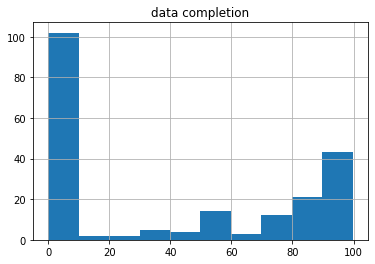

In [29]:
df[['data completion']].hist(bins=10)

As is common in eICU-CRD, there are a subset of hospitals who routinely utilize this portion of the medical record (and thus have 90-100% data completion), while there are other hospitals who rarely use this interface and thus have poor data completion (0-10%).